In [60]:
import os
from os.path import realpath, join
import sys
sys.path.insert(0, '/home/chuah/mitsuba3-camera/build/python')

import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

mi.set_variant('cuda_ad_dispersion')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
SCENE_DIR = realpath('../tutorials/scenes')

# Make sure that resources from the scene directory can be found
mi.Thread.thread().file_resolver().append(SCENE_DIR)

In [62]:
output_dir = realpath(join('.', 'outputs', 'lens'))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

[i] Results will be saved to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens


# Set lens parameters

In [63]:
def get_exact_Vd(lens_system):
    # https://phys.libretexts.org/Bookshelves/Optics/Geometric_Optics_(Tatum)/02%3A_Lens_and_Mirror_Calculations/2.10%3A_Designing_an_Achromatic_Doublet
    inv_c = lens_system.elements[0].surface.get_curvature()
    inv_b = -lens_system.elements[1].surface.get_curvature()
    inv_a = lens_system.elements[2].surface.get_curvature()
    n1 = lens_system.materials[2].params['ior']
    V1 = lens_system.materials[2].params['V_d']
    n2 = lens_system.materials[1].params['ior']

    P1 = (n1 - 1) * (inv_a + inv_b)
    P2 = -(n2 - 1) * (inv_b + inv_c)

    # P1 / V1 + P2 / V2 = 0
    return -(P2 / P1) * V1

Exact Vd: 6.861593997805768


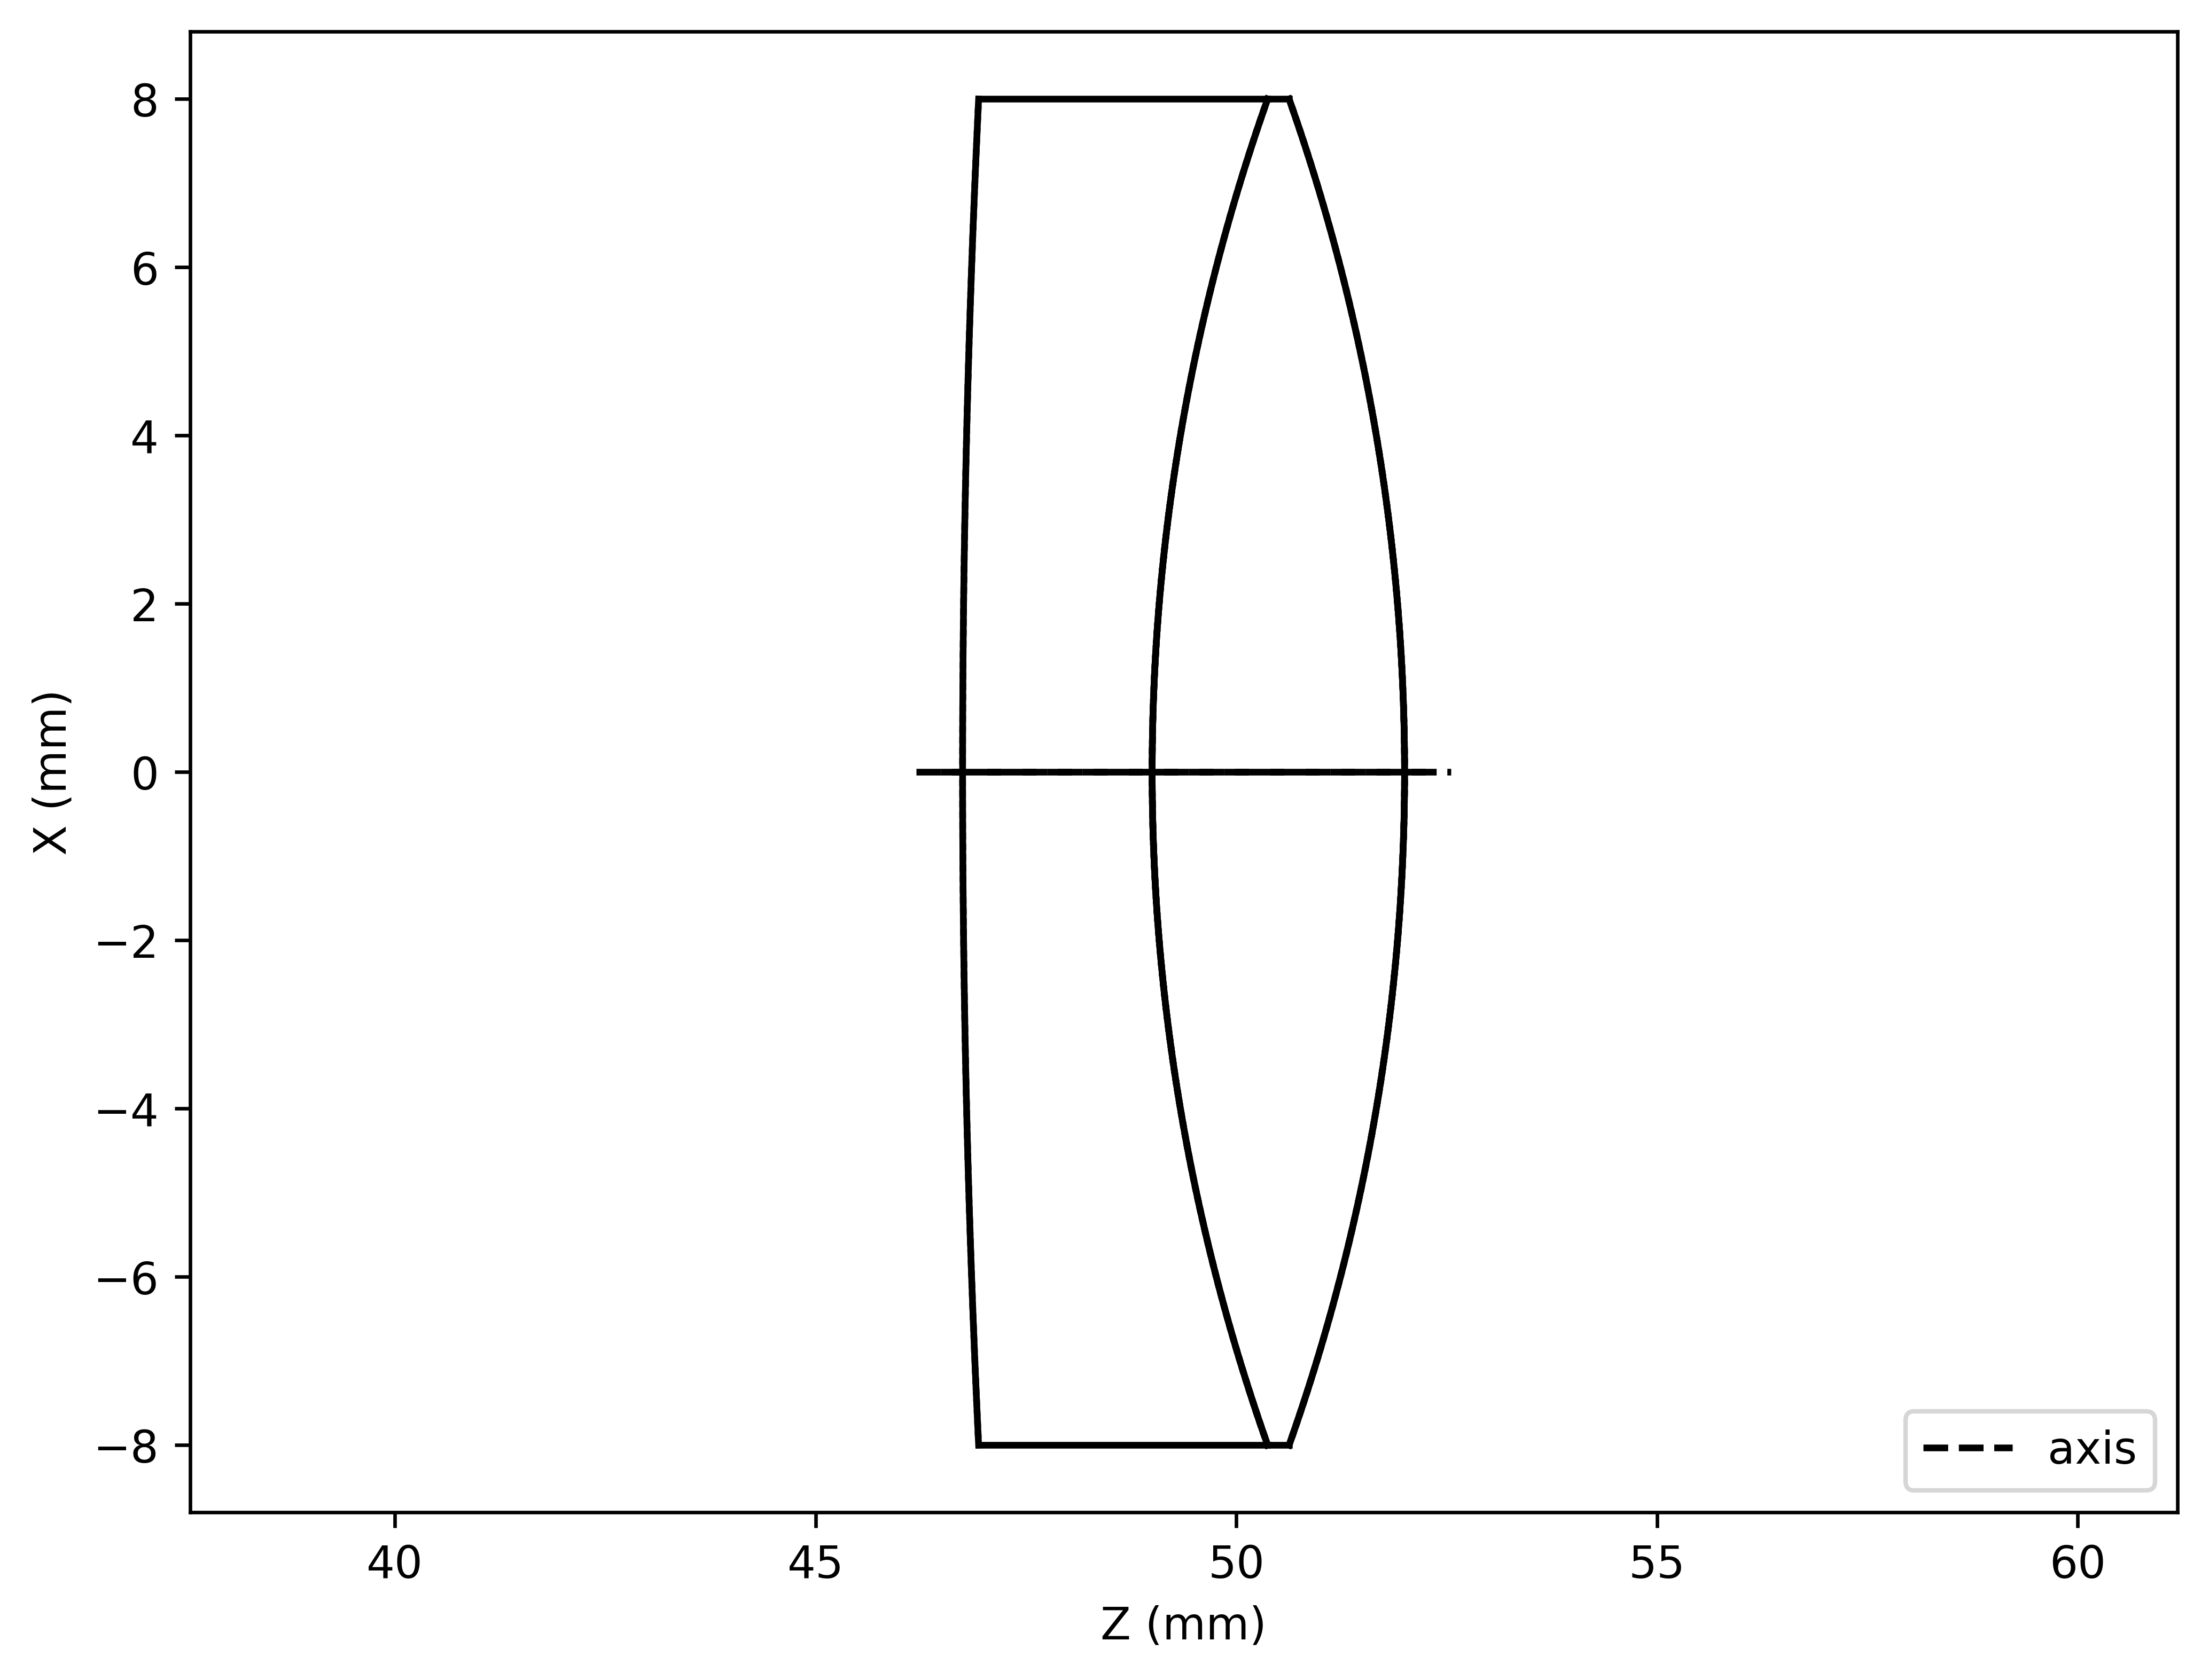

In [64]:
from scripts.lens_design.lens import ConicSurface, EvenAsphericSurface, LensMaterial, LensSystem
import numpy as np

surfs = [
        { 'radial_extent': 8.0, 'K': 0.0, 'c':  1/140, 'z0': 48 },
        { 'radial_extent': 8.0, 'K': 0.0, 'c':  -1/24, 'z0': 49 },
        { 'radial_extent': 8.0, 'K': 0.0, 'c':   1/24, 'z0': 52 },
        ]

# surfaces = [ConicSurface(**surf) for surf in surfs]
surfaces = [EvenAsphericSurface(**surf) for surf in surfs]
materials = [
        # LensMaterial("sf11", 1.7847, 25.76),
        LensMaterial("sf11", 1.6447, 0.2*64.17),
        LensMaterial("nbk7", 1.5168, 0.2*64.17), 
        ]
# aperture_index = len(surfaces) - 1
aperture_index = -1
lens_system = LensSystem(surfaces, materials, aperture_index=aperture_index)

target_focal_length = 50.0
# lens_system.disable_all_surfaces()
lens_system.disable_all_materials()
# lens_system.disable_material_vars("ior")
# lens_system.disable_var_in_material("V_d", 2)

# apply focal length constraint
s1_params = lens_system.get_rear_surface_params(target_focal_length)
lens_system.elements[0].surface.params['c'] = s1_params['c'].numpy().item()
lens_system.elements[0].surface.params['z0'] = s1_params['z0'].numpy().item()
lens_system.compute_paraxial_quantities()
Vd_exact = get_exact_Vd(lens_system)
print(f"Exact Vd: {Vd_exact}")

assert                                            0 < lens_system.elements[0].surface.params['z0']
assert lens_system.elements[0].surface.params['z0'] < lens_system.elements[1].surface.params['z0']
assert lens_system.elements[1].surface.params['z0'] < lens_system.elements[2].surface.params['z0']

fig = plt.figure(figsize=(8,6), dpi=600)
_ = lens_system.draw_cross_section(64,fig=fig)

In [65]:
lens_system.print()


====== Materials ======
mat[0]: 1.456079838959f, 0.021086562958f
mat[1]: 1.568952539042f, 0.026305160873f
mat[2]: 1.000277000000f, 0.000000000000f

====== Geometry ======
r_c: 24.00000000f, -24.00000000f, -168.01068267f
  t: 3.00000000f, 2.25291824f, 46.74708176f
r_e: 8.00000000f, 8.00000000f, 8.00000000f


[+] Wrote lens mesh (subdivs=7) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens0.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle0.ply
[+] Wrote lens mesh (subdivs=7) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens1.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle1.ply
[+] Wrote lens mesh (subdivs=7) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens2.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle2.ply
[0.0003799945116043091]
y is close:  False
[8.578179404139519e-06]
u is close:  True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


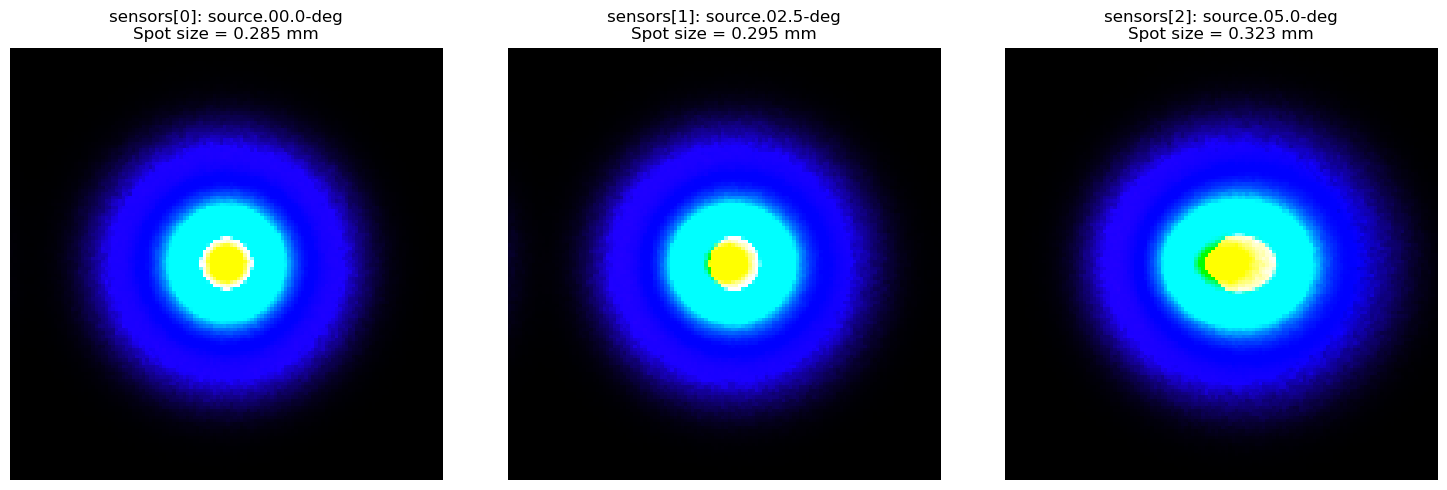

In [66]:
from scripts.lens_design.design_problem import DesignProblem

problem = DesignProblem(
    lens_system,
    resolution=(128, 128),
    spp=64*2,
    learning_rate=3e-1*0.0001,
    iters=300,
    output_dir=output_dir,
    num_sources=3,
    max_field_angle=5.0,
    init_camera_z=0.01,
    )

problem.prepare()
problem.plot_spots(scale=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


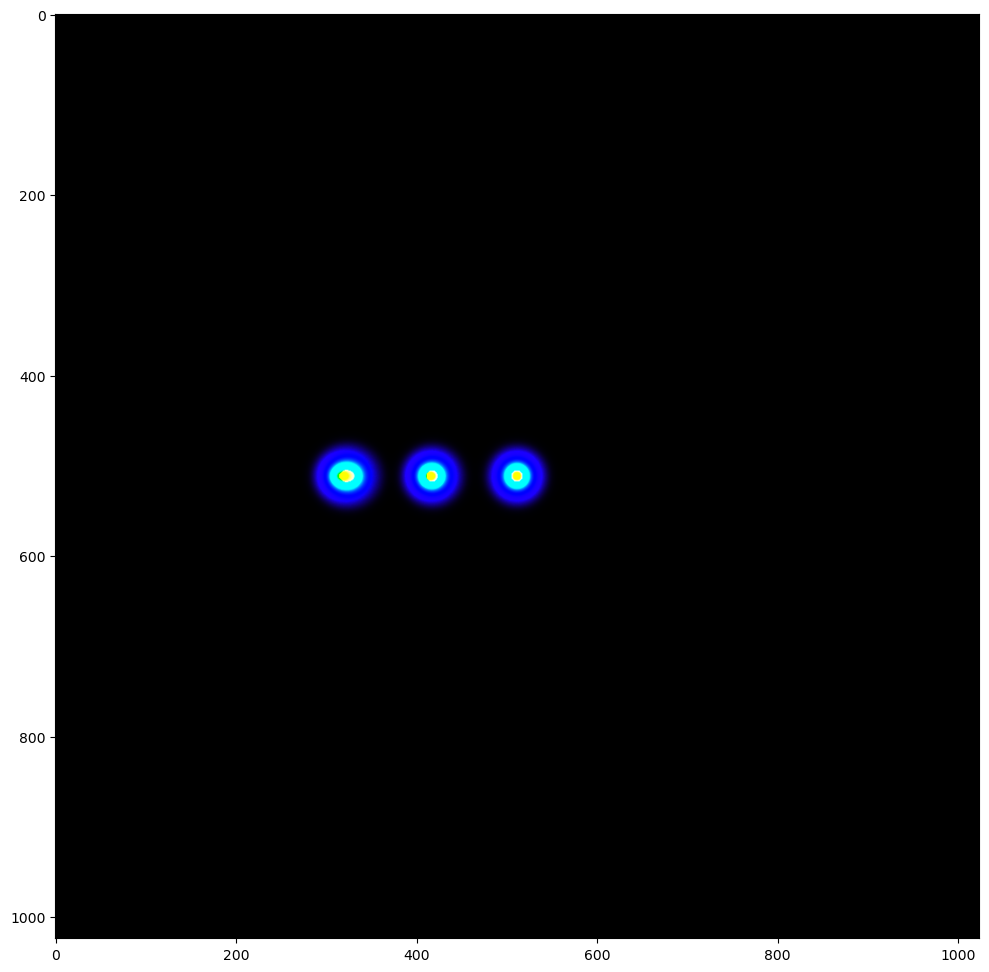

In [67]:
spots_init = problem.render(spp = 512, resolution = (1024, 1024), zoom_factor=0.1, sensor_idx=0)
plt.figure(figsize=(12,12))
plt.imshow(spots_init)

# mi.util.write_bitmap("caustic-test.exr", spots_init)

In [68]:
problem.optimizer.variables

{'lens0_c': [-0.04761601984500885],
 'lens0_K': [0.0],
 'lens0_z0': [46.7470817565918],
 'lens0_a4': [0.0],
 'lens0_a6': [0.0],
 'lens0_a8': [0.0],
 'lens0_a10': [0.0],
 'lens0_a12': [0.0],
 'lens0_a14': [0.0],
 'lens0_a16': [0.0],
 'lens1_c': [-0.3333333432674408],
 'lens1_K': [0.0],
 'lens1_z0': [49.0],
 'lens1_a4': [0.0],
 'lens1_a6': [0.0],
 'lens1_a8': [0.0],
 'lens1_a10': [0.0],
 'lens1_a12': [0.0],
 'lens1_a14': [0.0],
 'lens1_a16': [0.0],
 'lens2_c': [0.3333333432674408],
 'lens2_K': [0.0],
 'lens2_z0': [52.0],
 'lens2_a4': [0.0],
 'lens2_a6': [0.0],
 'lens2_a8': [0.0],
 'lens2_a10': [0.0],
 'lens2_a12': [0.0],
 'lens2_a14': [0.0],
 'lens2_a16': [0.0]}

In [69]:
losses, images_final, images_init, upsample_steps, sizes_init, sizes_final = problem.optimize()

2024-06-07 09:18:15 WARN main [Mesh] Mesh::build_directed_edges(): there are 1280 non-manifold vertices in the follwing mesh: PLYMesh[
2024-06-07 09:18:15 WARN main [Mesh] name = "baffle2.ply",
2024-06-07 09:18:15 WARN main [Mesh] bbox = BoundingBox3f[
2024-06-07 09:18:15 WARN main [Mesh] min = [-8.8, -8.8, 50.6274],
2024-06-07 09:18:15 WARN main [Mesh] max = [8.8, 8.8, 50.6274]
2024-06-07 09:18:15 WARN main [Mesh] ],
2024-06-07 09:18:15 WARN main [Mesh] vertex_count = 1280,
2024-06-07 09:18:15 WARN main [Mesh] vertices = [30 KiB of vertex data],
2024-06-07 09:18:15 WARN main [Mesh] face_count = 2560,
2024-06-07 09:18:15 WARN main [Mesh] faces = [30 KiB of face data],
2024-06-07 09:18:15 WARN main [Mesh] face_normals = 0
2024-06-07 09:18:15 WARN main [Mesh] ]

2024-06-07 09:18:15 WARN main [Mesh] Mesh::build_directed_edges(): there are 1280 non-manifold vertices in the follwing mesh: PLYMesh[
2024-06-07 09:18:15 WARN main [Mesh] name = "baffle1.ply",
2024-06-07 09:18:15 WARN main [Mesh] bbox = BoundingBox3f[
2024-06-07 09:18:15 WARN main [Mesh] min = [-8.8, -8.8, 50.3726],
2024-06-07 09:18:15 WARN main [Mesh] max = [8.8, 8.8, 50.3726]
2024-06-07 09:18:15 WARN main [Mesh] ],
2024-06-07 09:18:15 WARN main [Mesh] vertex_count = 1280,
2024-06-07 09:18:15 WARN main [Mesh] vertices = [30 KiB of vertex data],
2024-06-07 09:18:15 WARN main [Mesh] face_count = 2560,
2024-06-07 09:18:15 WARN main [Mesh] faces = [30 KiB of face data],
2024-06-07 09:18:15 WARN main [Mesh] face_normals = 0
2024-06-07 09:18:15 WARN main [Mesh] ]

2024-06-07 09:18:15 WARN main [Mesh] Mesh::build_directed_edges(): there are 1280 non-manifold vertices in the follwing mesh: PLYMesh[
2024-06-07 09:18:15 WARN main [Mesh] name = "baffle0.ply",
2024-06-07 09:18:15 WARN main [Mesh] bbox = BoundingBox3f[
2024-06-07 09:18:15 WARN main [Mesh] min = [-8.8, -8.8, 46.9377],
2024-06-07 09:18:15 WARN main [Mesh] max = [8.8, 8.8, 46.9377]
2024-06-07 09:18:15 WARN main [Mesh] ],
2024-06-07 09:18:15 WARN main [Mesh] vertex_count = 1280,
2024-06-07 09:18:15 WARN main [Mesh] vertices = [30 KiB of vertex data],
2024-06-07 09:18:15 WARN main [Mesh] face_count = 2560,
2024-06-07 09:18:15 WARN main [Mesh] faces = [30 KiB of face data],
2024-06-07 09:18:15 WARN main [Mesh] face_normals = 0
2024-06-07 09:18:15 WARN main [Mesh] ]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


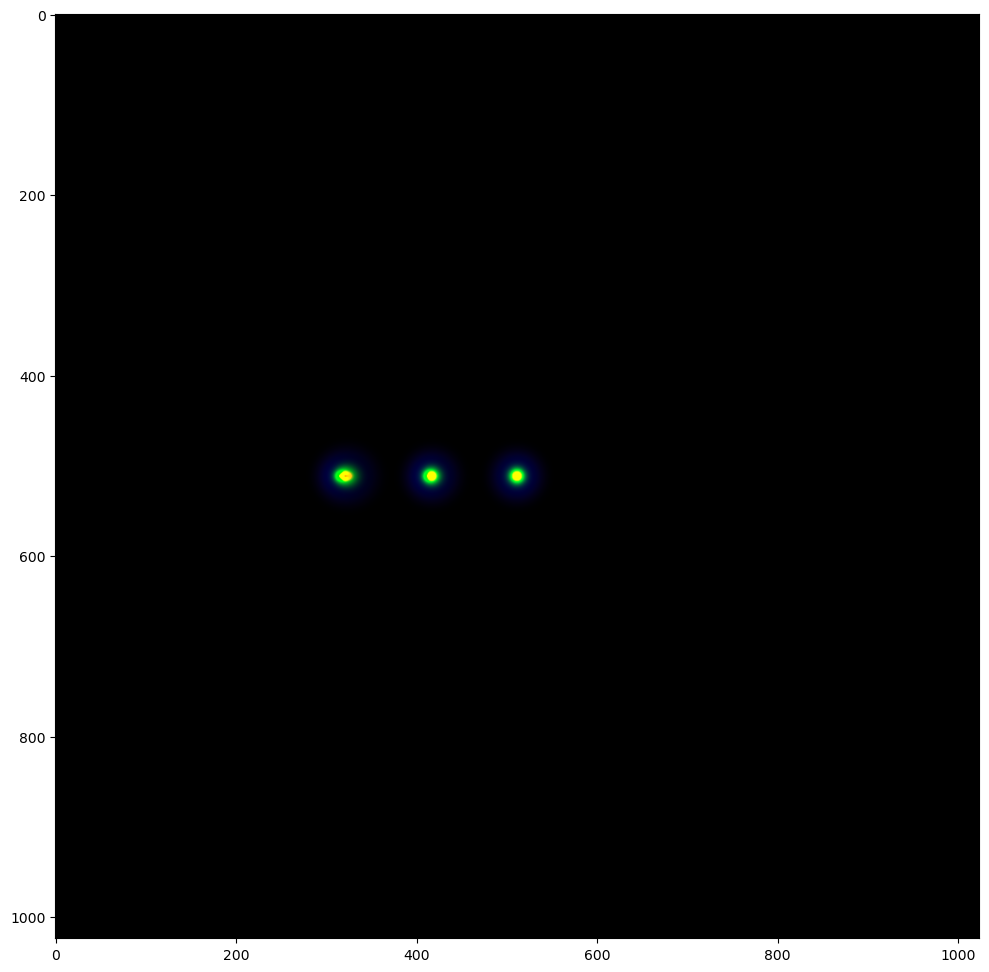

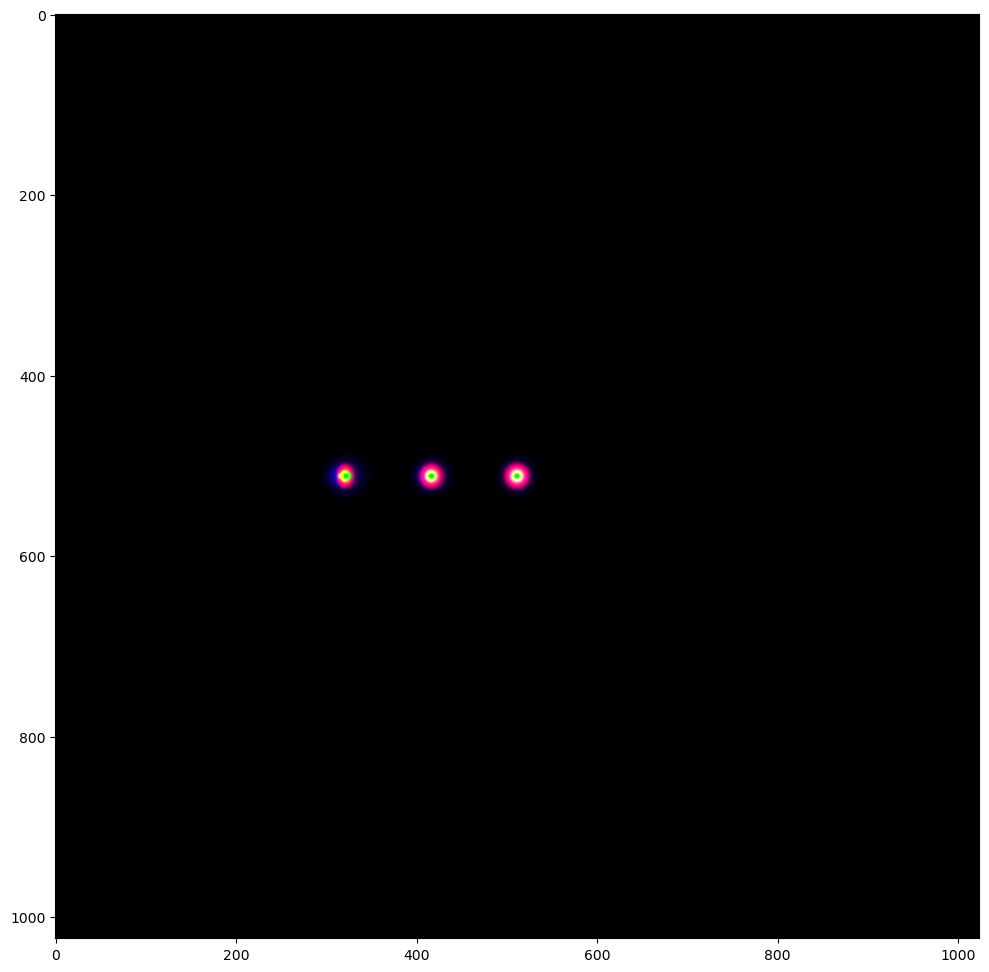

In [70]:
spots_final = problem.render(spp = 512, resolution = (1024, 1024), zoom_factor=0.1 / 2 ** upsample_steps)
plt.figure(figsize=(12,12))
plt.imshow(0.1 * spots_init)
plt.figure(figsize=(12,12))
plt.imshow(0.1 * spots_final)

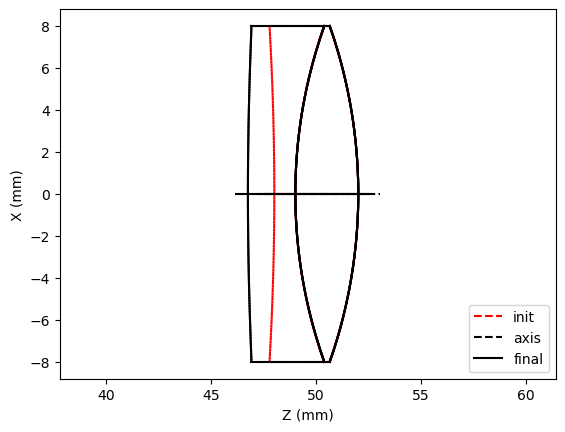

In [71]:
# plt.legend()
lens_init = LensSystem([ConicSurface(**surf) for surf in surfs], materials, aperture_index=aperture_index)
fig = lens_init.draw_cross_section(64, color='r', linestyle='--', label="init")
_ = lens_system.draw_cross_section(64, color='k', fig=fig, label='final')
# c = 60.84
# dx = 0.01
# dy = 0.01
# plt.xlim([c-dx,c+dx])
# plt.ylim([-dy,dy])

In [72]:
print(f"Upsampling steps: {upsample_steps}")

Upsampling steps: 0


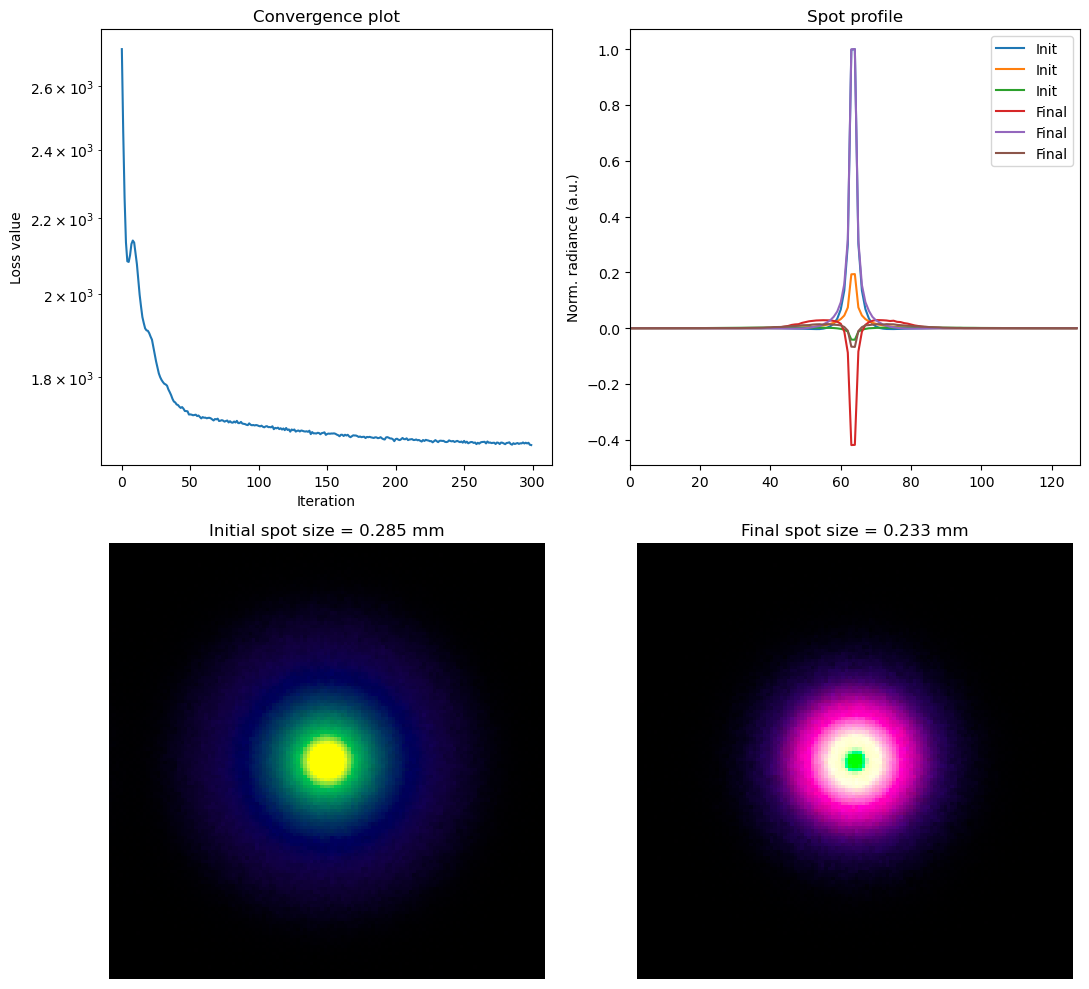

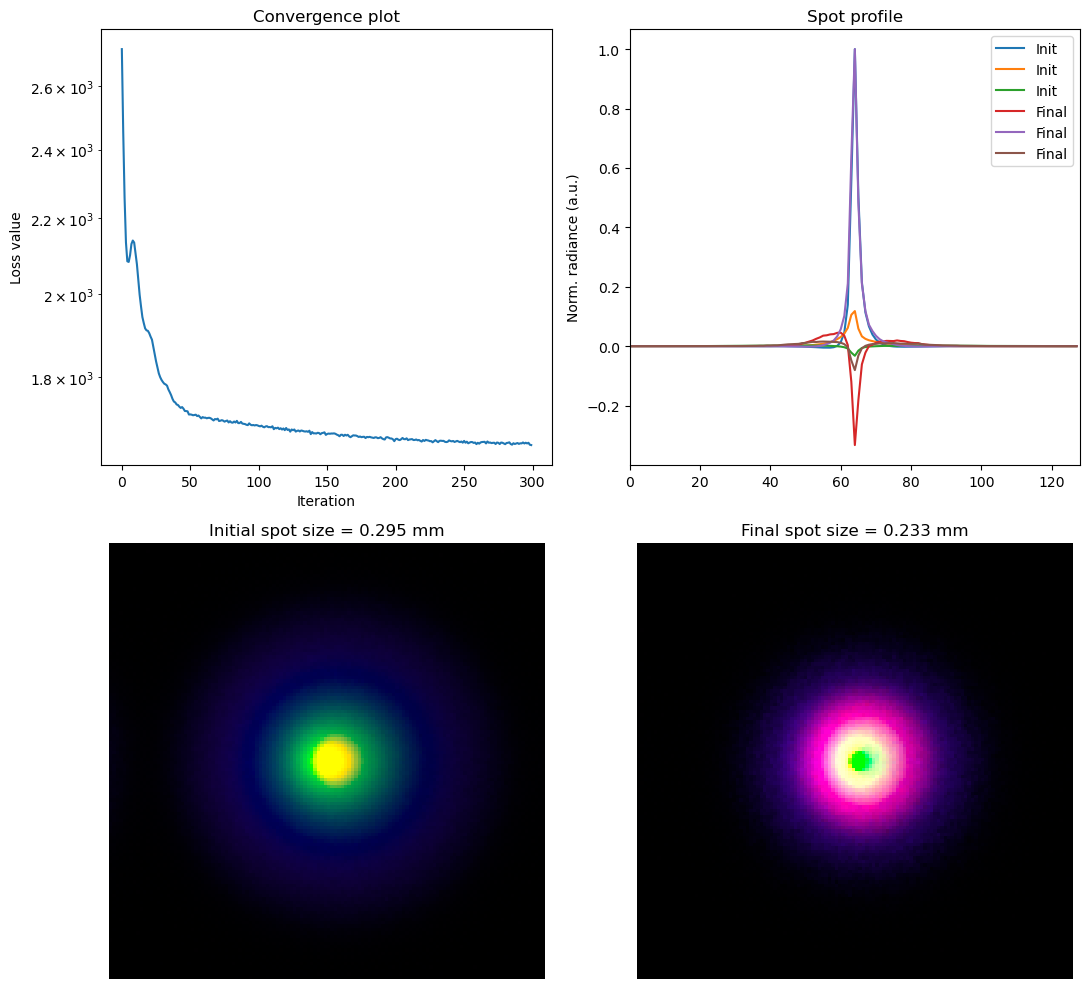

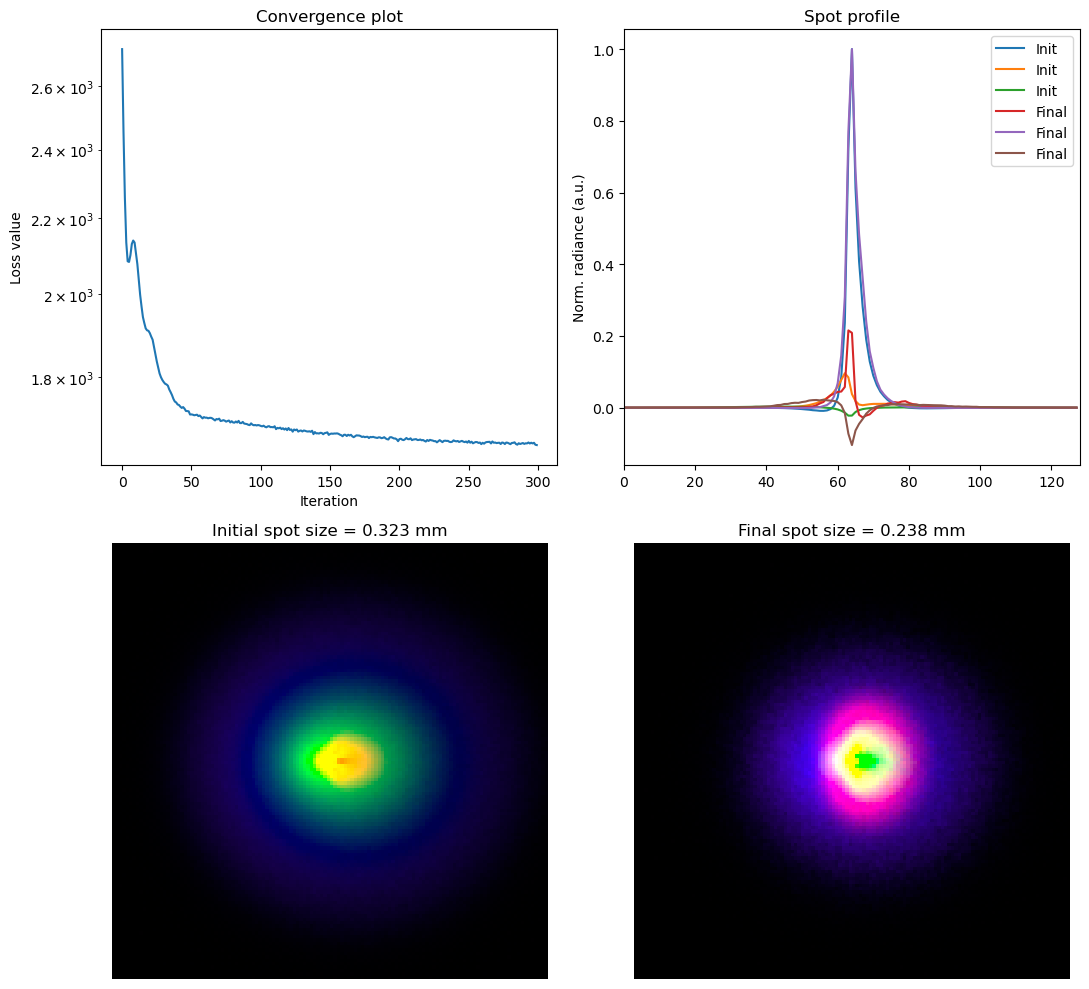

In [73]:
from scripts.lens_design.design_problem import plot_progress

for image_i, image_f, spot_size_init, spot_size_final in zip(images_init, images_final, sizes_init, sizes_final):
    _ = plot_progress(image_i, image_f, spot_size_init, spot_size_final, losses, upsample_steps, False)
    # mi.util.write_bitmap("spot_i.exr", image_i)
    # mi.util.write_bitmap("spot_f.exr", image_f)


In [78]:
for m in problem.lens_system.materials:
    print(m.params)
print(problem.lens_system.elements[0].surface.params)
print(problem.lens_system.elements[1].surface.params)


{'ior': 1.000277, 'V_d': 0.0}
{'ior': 1.6447, 'V_d': 6.861593997805768}
{'ior': 1.5168, 'V_d': 12.834000000000001}
{'c': [-0.04504023864865303], 'K': [-0.0009244396933354437], 'z0': [46.74386215209961], 'a4': [0.0009508539224043489], 'a6': [0.00010412279516458511], 'a8': [-0.00014858432405162603], 'a10': [-0.00010279302659910172], 'a12': [5.96465433773119e-05], 'a14': [0.0002553249360062182], 'a16': [0.0004504272947087884]}
{'c': [-0.3356727659702301], 'K': [0.0006883303285576403], 'z0': [49.002906799316406], 'a4': [-0.0007925858371891081], 'a6': [9.541663166601211e-05], 'a8': [0.00038140988908708096], 'a10': [0.0003720808308571577], 'a12': [0.0002486447338014841], 'a14': [9.209151903633028e-05], 'a16': [-6.504303746623918e-05]}
